In [9]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable


from tensorflow.python.client import device_lib

In [2]:
def get_mask_data():

    x_train_path = "dataset/Infection/mask_infection.npy"
    x_val_path = "dataset/Infection/mask_infection_val.npy"
    x_test_path = "dataset/Infection/mask_infection_test.npy"
    y_train_path = "dataset/Infection/y_train.npy"
    y_val_path = "dataset/Infection/y_val.npy"
    y_test_path = "dataset/Infection/y_test.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    x_test = np.load(x_test_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)
    y_test = np.load(y_test_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    print(x_test.shape, y_test.shape)
    
        
    return x_train, x_val, x_test, y_train, y_val, y_test


In [3]:
def VGG16_Unet(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16       #feature map 수
    kernel_size = 3    # kernel size
    copy_layers = []   # Encoder에 있는 Activation map을 저장하는 리스트
    net = inputs
  
    #Encoder1
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #첫번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder2 
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #두번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder3
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #세번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder4
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #네번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #Encoder5
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #다섯번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    
    #Decoder : upsampling
    j = len(copy_layers) - 1
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #다섯번째 Activation map 
    
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    j = j -1 

    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #네번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #세번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #두번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #첫번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    outputs = Conv2D(1, 1, activation='sigmoid') (net)




    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.MeanIoU(num_classes=3)])

    model.summary()
    
    
    

    return model

In [4]:
def training(model,x_train, y_train, x_val, y_val) :
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=16, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')
    
    ax[2,0].set_title('MeanIoU')
    ax[2,0].plot(history.history['mean_io_u'], 'r')
    ax[2,1].set_title('val_MeanIoU')
    ax[2,1].plot(history.history['val_mean_io_u'], 'r')

    preds = model.predict(x_val)

    fig, ax = plt.subplots(40, 3, figsize=(10, 100))
    
    temp = np.empty((256, 256, 1), dtype=np.float32)

    for i in range(40):
        ax[i, 0].imshow(x_val[i].squeeze(), cmap='hot')
        ax[i, 0].title.set_text(str(i))
        ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
        ax[i, 2].imshow(preds[i].squeeze(), cmap='gray')
#         temp = x_val[i]
#         pred_sum = preds[i][preds[i] > 0]
#         pred_mean = np.mean(pred_sum)
#         if(np.min(temp) >= 0) :
#             temp[preds[i] < pred_mean] = 0
#         else :
#             temp[preds[i] < pred_mean] = -2048
#         ax[i, 3].imshow(temp.squeeze(), cmap='gray')


(2380, 256, 256, 1) (2380, 256, 256, 1)
(295, 256, 256, 1) (295, 256, 256, 1)
(298, 256, 256, 1) (298, 256, 256, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d_1[0][

Epoch 1/30
149/149 [==============================] - 91s 501ms/step - loss: 0.4759 - acc: 0.9442 - mean_io_u: 1.0000 - val_loss: 0.2656 - val_acc: 0.9853 - val_mean_io_u: 1.0000
Epoch 2/30
149/149 [==============================] - 67s 448ms/step - loss: 0.1459 - acc: 0.9862 - mean_io_u: 1.0000 - val_loss: 0.0541 - val_acc: 0.9858 - val_mean_io_u: 1.0000
Epoch 3/30
149/149 [==============================] - 67s 451ms/step - loss: 0.0246 - acc: 0.9862 - mean_io_u: 1.0000 - val_loss: 0.0071 - val_acc: 0.9858 - val_mean_io_u: 1.0000
Epoch 4/30
149/149 [==============================] - 67s 453ms/step - loss: 0.0031 - acc: 0.9862 - mean_io_u: 1.0000 - val_loss: 0.0038 - val_acc: 0.9857 - val_mean_io_u: 1.0000
Epoch 5/30
149/149 [==============================] - 68s 454ms/step - loss: 9.3312e-04 - acc: 0.9862 - mean_io_u: 1.0000 - val_loss: 0.0022 - val_acc: 0.9856 - val_mean_io_u: 1.0000
Epoch 6/30
149/149 [==============================] - 67s 453ms/step - loss: 7.9576e-04 - acc: 0.9862

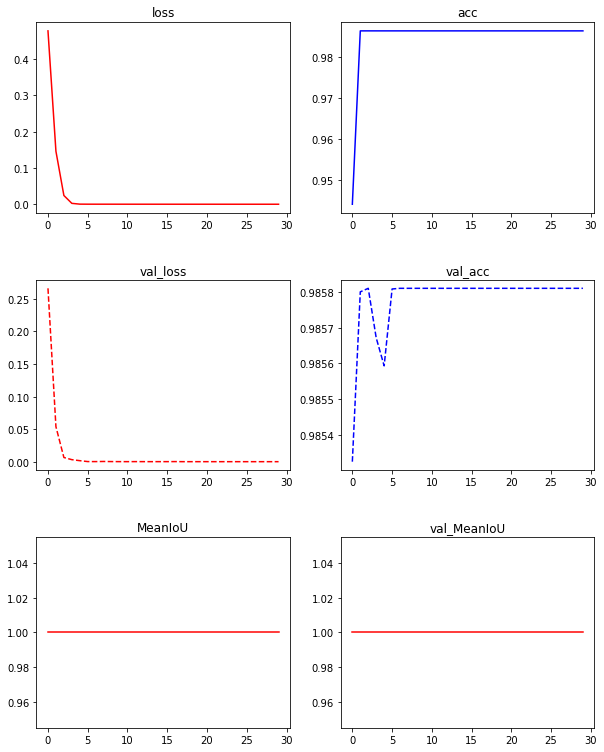

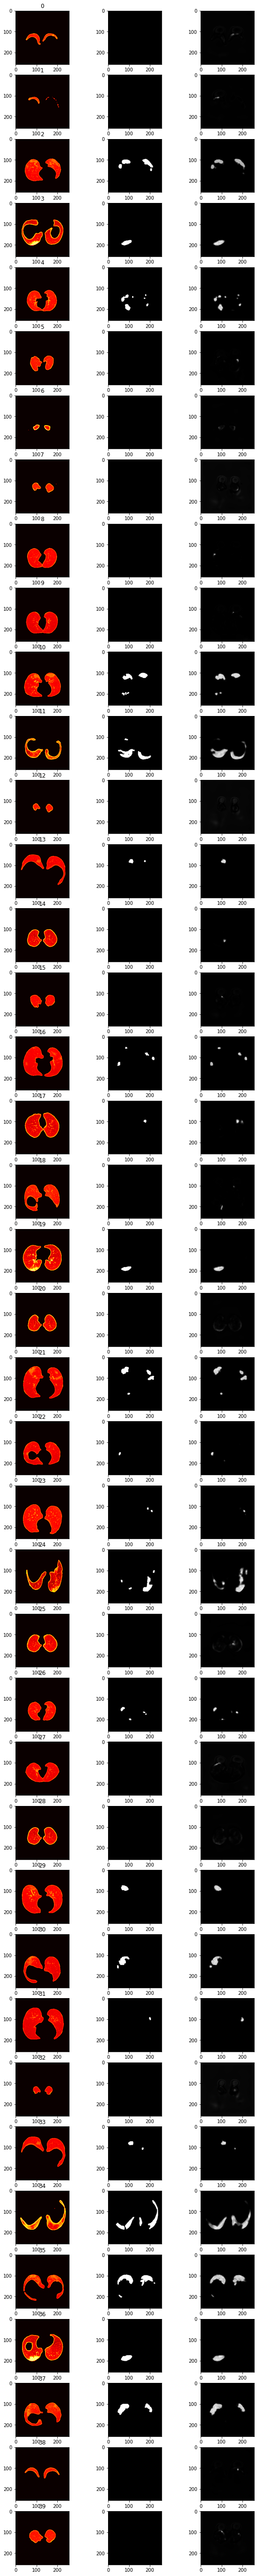

In [5]:
x_train,x_val,x_test, y_train, y_val, y_test = get_mask_data()
model = VGG16_Unet(x_train, y_train, x_val, y_val)
history = training(model,x_train, y_train, x_val, y_val)

In [6]:
def get_data() :
    x_test_path = "dataset/Infection/mask_infection_test.npy"
    y_test_path = "dataset/Infection/y_test.npy"
    
    x_test = np.load(x_test_path)
    y_test = np.load(y_test_path)

    print(x_test.shape, y_test.shape)
    
        
    return x_test, y_test

(298, 256, 256, 1) (298, 256, 256, 1)


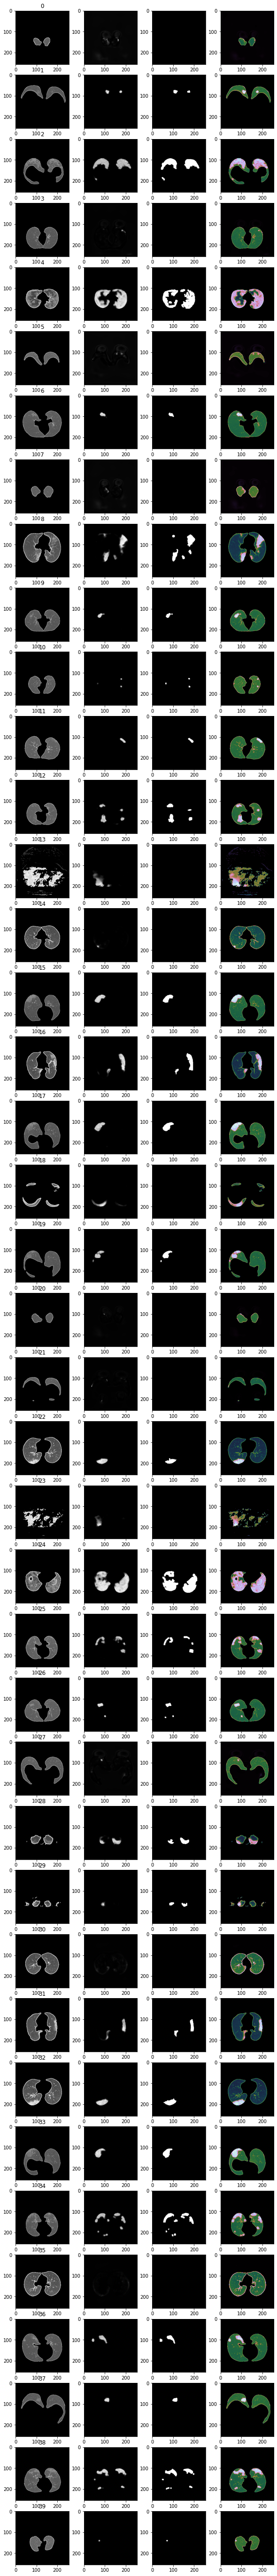

In [36]:
x_test, y_test = get_data()
predic = model.predict(x_test)


fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
temp = np.empty((256, 256, 1), dtype=np.float32)

for i in range(40):
    ax[i, 0].imshow(x_test[i].squeeze(), cmap='gray')
    ax[i, 0].title.set_text(str(i))
    ax[i, 1].imshow(predic[i].squeeze(), cmap='gray')
#     print(i, " : ", np.max(predic[i]))
    ax[i, 2].imshow(y_test[i].squeeze(), cmap='gray')
#     predic[i] = (predic[i]/ np.max(predic[i])) * 255
#     temp = cv2.add(x_test[i], predic[i])
#     temp = x_test[i]
    pred_sum = predic[i][predic[i] > 0]
    pred_mean = np.mean(pred_sum)
    if(np.min(x_test[i]) >= 0) :
#         temp[predic[i] < pred_mean] = 0
        predic[i] = (predic[i]/ np.max(predic[i])) * 255
        temp = cv2.add(x_test[i], predic[i])
    else :
#         temp[predic[i] < pred_mean] = -2048
        predic[i] = (predic[i]/ np.max(predic[i])) * 2048
        temp = cv2.add(x_test[i], predic[i])
    ax[i, 3].imshow(temp.squeeze(), cmap='cubehelix')
##cubehelix 
#     ax[i, 3].imshow(temp.squeeze(), cmap='hot')
# temp = predic[4] / np.min(predic[4]) * 255

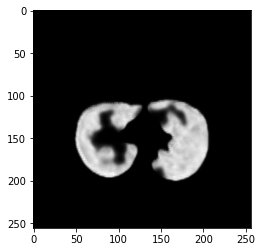

In [15]:
plt.imshow(temp.squeeze(), cmap='gray')